In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.dates as mdates
import pytz

# sklearn imports
from sklearn.model_selection import train_test_split

# oma_tracking imports
from oma_tracking.data.preprocessing import sin_cos_angle_inputs

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import unpack_mode, get_frequencies, get_rated_data, get_parked_data, read_simulations_csv_files

from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [3]:
user = os.getenv('API_USERNAME') 
password = os.getenv('API_PASSWORD')
root = r"http://10.0.0.138/api/v1/"
owi = API(api_root=root, username=user, password=password)
locations = owi.groups['locations'][4]
owi.groups

,project,locations,datagroups
id,,,
1,prj_smartbridge,"[mo01, opzuid]","[acceleration, fiber, mpe]"
2,nobelwind,"[bbg10, bbk05, bbg08]","[acceleration, bolt, corrosion, fatigue, incli..."
3,parkwind_northwester2,"[nw2e01, nw2f01, nw2d01]",[scada]
4,parkwind,[bbc01],"[acceleration, mpe, scada]"
5,parkwind_northwester2,"[nw2e01, nw2f01, nw2d01, nw2a01, nw2a02, nw2a0...","[acceleration, mpe, scada]"


Location:  nw2e01 name_location:  NW2_E01
Loading data from local source
0:	learn: -4.8831741	total: 149ms	remaining: 14.7s
1:	learn: -4.8906966	total: 155ms	remaining: 7.62s
2:	learn: -4.8980128	total: 164ms	remaining: 5.3s
3:	learn: -4.9012976	total: 173ms	remaining: 4.16s
4:	learn: -4.9041819	total: 182ms	remaining: 3.46s
5:	learn: -4.9073145	total: 189ms	remaining: 2.95s
6:	learn: -4.9111284	total: 199ms	remaining: 2.64s
7:	learn: -4.9165206	total: 208ms	remaining: 2.4s
8:	learn: -4.9196748	total: 216ms	remaining: 2.18s
9:	learn: -4.9231748	total: 222ms	remaining: 2s
10:	learn: -4.9259326	total: 233ms	remaining: 1.88s
11:	learn: -4.9308979	total: 241ms	remaining: 1.77s
12:	learn: -4.9346613	total: 249ms	remaining: 1.66s
13:	learn: -4.9366782	total: 254ms	remaining: 1.56s
14:	learn: -4.9415326	total: 270ms	remaining: 1.53s
15:	learn: -4.9429570	total: 282ms	remaining: 1.48s
16:	learn: -4.9445949	total: 290ms	remaining: 1.42s
17:	learn: -4.9465629	total: 299ms	remaining: 1.36s
18:	le

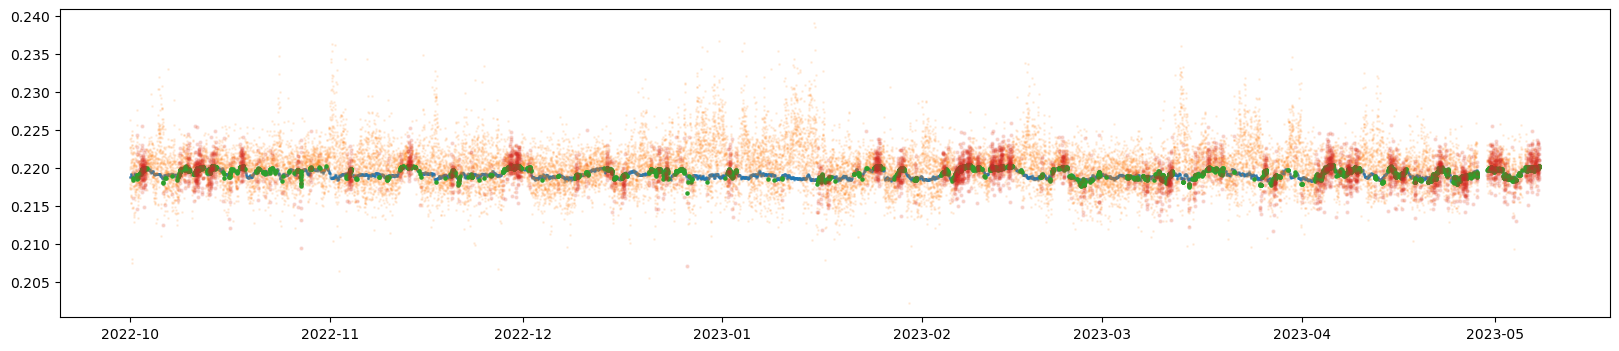

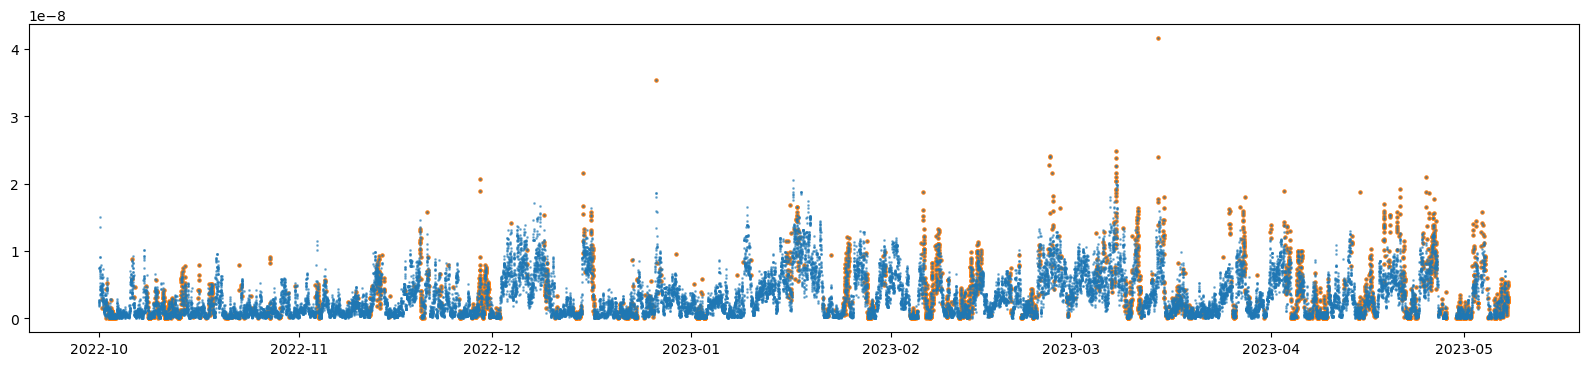

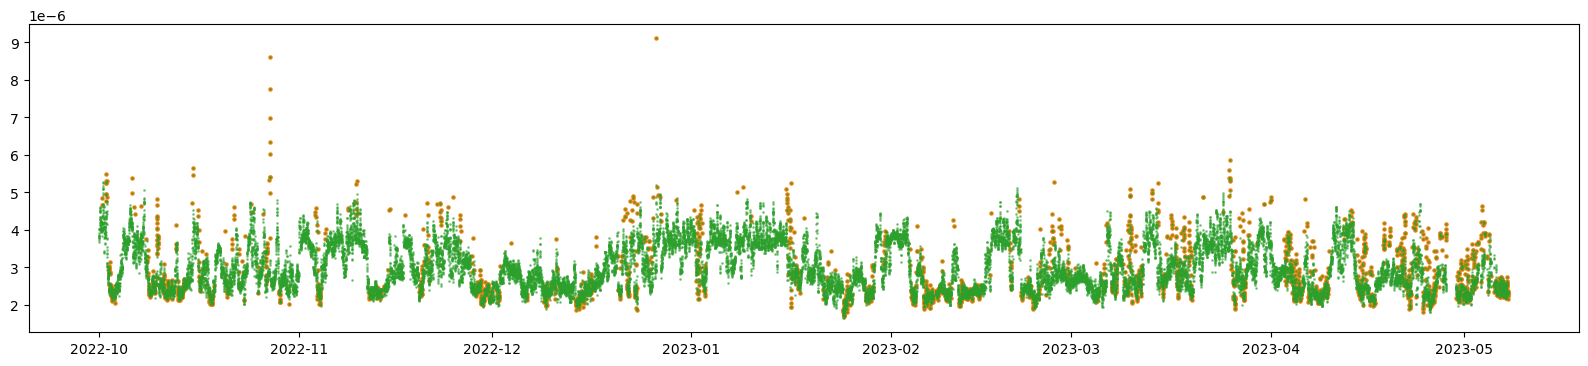

Test data plots


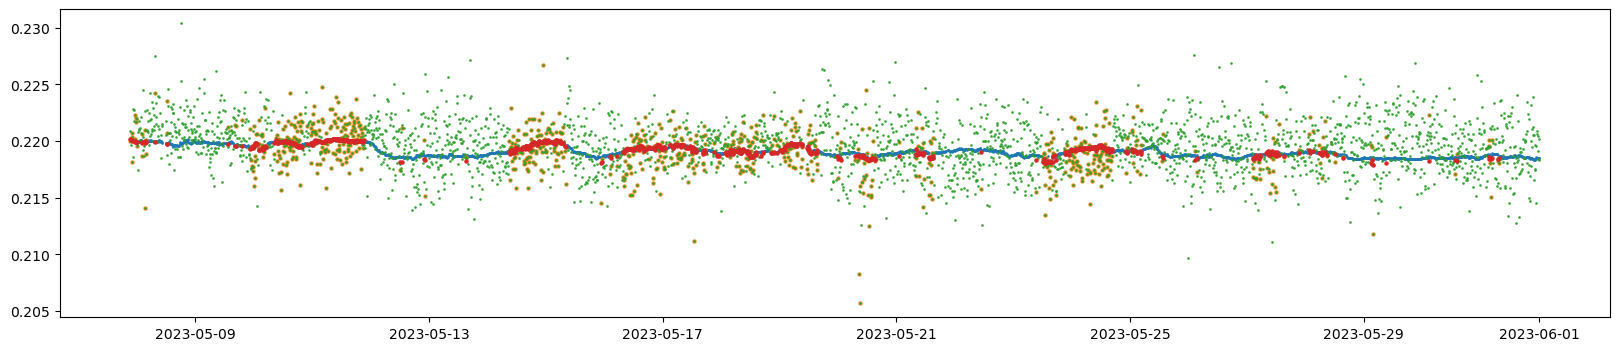

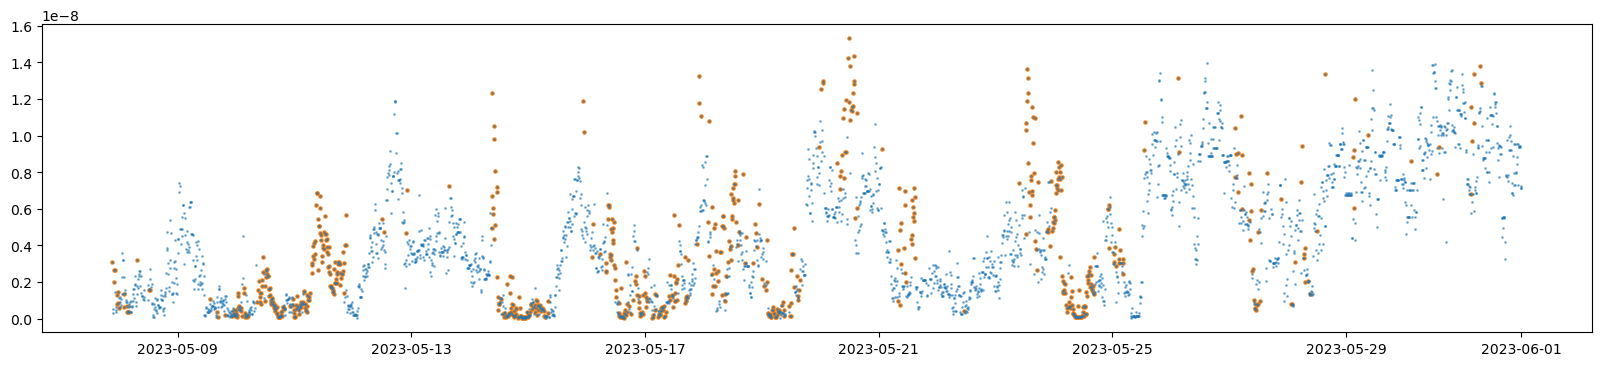

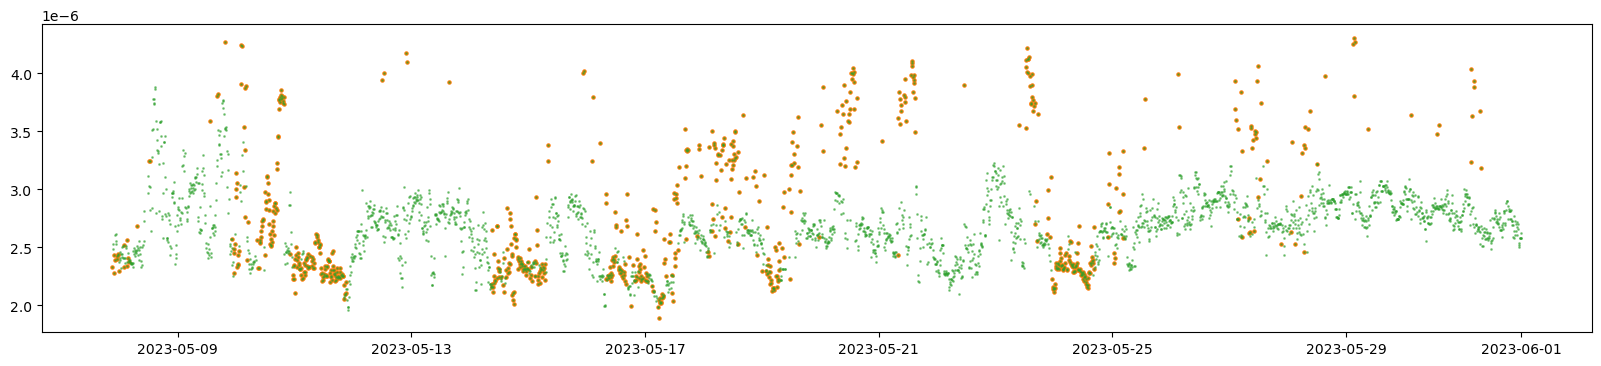

In [4]:
start  = datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,8,1,tzinfo=utc)

for location in locations[0:1]:
    name_location = '_'.join(['NW2', location.split('nw2')[1].upper()])
    home_folder = "../../"
    print("Location: ", location, "name_location: ", name_location)


    ### DATA HANDLING 
    ## Load turbine data
    try:
        # Load data from local source
        print("Loading data from local source")
        data_path = os.path.join(home_folder, "data", "nw2", "raw", location + ".parquet")
        turbine_data = pd.read_parquet(data_path)
    
    except:
        # Load data from API
        print("Loading data from API")
        dsg = DatasetGetter(start, stop, location)
        dsg.get_longterm_data()
        dsg.save_data(data_path)
        turbine_data = dsg.data

    ## Load weather station data
    weather_data_path = "../../data/nw2/mvbc_data.parquet"
    weather_station_data = pd.read_parquet(weather_data_path)

    ## Load the tracked modes   
    modes = ['SS1']
    tracked_modes_data = {}
    for mode in modes:
        mode_data_path = os.path.join(home_folder, "data", "nw2", "tracked_modes", "_".join([mode, location.upper()]) + ".parquet")
        tracked_modes_data[mode] = pd.read_parquet(mode_data_path)


    ### DATA PREPROCESSING

    ## Select the appropriate data frome the turbine data

    # The data is filtered to only include the mean values of the variables
    means_data = turbine_data.filter(regex = 'mean')
    # The data is filtered to remove the ACC data and only keep the SCADA
    means_SCADA_data = means_data.drop(columns = means_data.filter(regex = 'acc|ACC').columns)
    # The cyclic data and angles are transformed to sin and cos
    means_SCADA_data = sin_cos_angle_inputs(means_SCADA_data, angle_type = 'degrees', angles = ['winddirection', 'yaw'])
    # The data is filtered to only include variables with less than 5% missing values
    monitoring_inputs = means_SCADA_data.loc[:, means_SCADA_data.isna().sum() < 0.05 * means_SCADA_data.shape[0]]

    for mode in modes:
        tracked_mode = tracked_modes_data[mode]['frequency'].dropna()
        unique_tracked_mode = tracked_mode.groupby(tracked_mode.index).filter(lambda x: len(x) == 1)
        inputs_ = pd.concat([monitoring_inputs, weather_station_data], axis=1)
        # keep inputs with more than 75% of the data
        inputs = inputs_.loc[:, inputs_.isna().sum() < 0.25 * inputs_.shape[0]]
        y = unique_tracked_mode
        X = inputs.loc[y.index].dropna()
        X_parked = get_parked_data(X)
        y = y.loc[X.index]
        y_parked = y.loc[X_parked.index]

        # Split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
        X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=123)

        # Split the parked data into train and test
        X_train_parked, X_test_parked, y_train_parked, y_test_parked = train_test_split(X_parked, y_parked, test_size=0.1, shuffle=False)
        X_train_parked_, X_val_parked, y_train_parked_, y_val_parked = train_test_split(X_train_parked, y_train_parked, test_size=0.1, shuffle=True, random_state=123)

        rpm_split = 5

        X_lowrpm = X.loc[X.filter(regex = 'rpm')[X.filter(regex = 'rpm') < rpm_split].dropna().index]
        y_lowrpm = y.loc[X_lowrpm.index]

        X_lowrpm_train = X_train.loc[X_train.filter(regex = 'rpm')[X_train.filter(regex = 'rpm') < rpm_split].dropna().index]
        y_lowrpm_train = y_train.loc[X_lowrpm_train.index]
        X_lowrpm_test = X_test.loc[X_test.filter(regex = 'rpm')[X_test.filter(regex = 'rpm') < rpm_split].dropna().index]
        y_lowrpm_test = y_test.loc[X_lowrpm_test.index]

        cb_regr = CatBoostRegressor(iterations=100, random_seed=13, posterior_sampling=True, loss_function='RMSEWithUncertainty')
        cb_regr.fit(X_lowrpm_train, y_lowrpm_train)


        inputs_ = X_train.dropna()
        targets_ = y_train

        preds = cb_regr.virtual_ensembles_predict(inputs_, prediction_type='TotalUncertainty') #, virtual_ensembles_count=100, ntree_end=200)
        preds_df = pd.DataFrame(preds, columns=['mean', 'knowledge', 'data'], index=inputs_.index)

        mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
        knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
        data = preds[:,2] # average estimated data uncertainty

        parked_preds = cb_regr.virtual_ensembles_predict(X_lowrpm_train, prediction_type='TotalUncertainty') #, virtual_ensembles_count=100, ntree_end=200)
        parked_preds_df = pd.DataFrame(parked_preds, columns=['mean', 'knowledge', 'data'], index=X_lowrpm_train.index)

        parked_mean_preds = parked_preds[:,0] # mean values predicted by a virtual ensemble
        parked_knowledge = parked_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
        parked_data = parked_preds[:,2] # average estimated data uncertainty

        print('Train data plots')

        plt.figure(figsize=(20,4))
        plt.scatter(inputs_.index, mean_preds, label='predictions', s=1, alpha=0.1)
        plt.scatter(targets_.index, targets_, label='actual', s=1, alpha=0.1)
        plt.scatter(parked_preds_df.index, parked_preds_df['mean'], label='parked predictions', s=5, alpha=1.0)
        plt.scatter(y_lowrpm_train.index, y_lowrpm_train, label='parked', s=5, alpha=0.1)
        plt.show()
        plt.figure(figsize=(20,4))
        plt.scatter(parked_preds_df['knowledge'].index, parked_preds_df['knowledge'],s=5, alpha=1.0, color='tab:orange')
        plt.scatter(preds_df['knowledge'].index, preds_df['knowledge'], alpha=0.5, color='tab:blue',s=1)
        plt.show()
        plt.figure(figsize=(20,4))
        plt.scatter(parked_preds_df['data'].index, parked_preds_df['data'], s=5, alpha=1.0, color='tab:orange')
        plt.scatter(preds_df['data'].index, preds_df['data'],s=1, alpha=0.5, color='tab:green')
        plt.show()

        print('Test data plots')

        inputs_ = X_test.dropna()
        targets_ = y_test

        preds = cb_regr.virtual_ensembles_predict(inputs_, prediction_type='TotalUncertainty') #, virtual_ensembles_count=100, ntree_end=200)
        preds_df = pd.DataFrame(preds, columns=['mean', 'knowledge', 'data'], index=inputs_.index)

        mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
        knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
        data = preds[:,2] # average estimated data uncertainty

        parked_preds = cb_regr.virtual_ensembles_predict(X_lowrpm_test, prediction_type='TotalUncertainty') #, virtual_ensembles_count=100, ntree_end=200)
        parked_preds_df = pd.DataFrame(parked_preds, columns=['mean', 'knowledge', 'data'], index=X_lowrpm_test.index)

        parked_mean_preds = parked_preds[:,0] # mean values predicted by a virtual ensemble
        parked_knowledge = parked_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
        parked_data = parked_preds[:,2] # average estimated data uncertainty

        plt.figure(figsize=(20,4))
        plt.scatter(inputs_.index, mean_preds, label='predictions', s=1, alpha=0.8)
        plt.scatter(y_lowrpm_test.index, y_lowrpm_test, label='parked', s=5, alpha=0.8)
        plt.scatter(targets_.index, targets_, label='actual', s=1, alpha=0.8)
        plt.scatter(parked_preds_df.index, parked_preds_df['mean'], label='parked predictions', s=5, alpha=1.0)

        plt.show()
        plt.figure(figsize=(20,4))
        plt.scatter(parked_preds_df['knowledge'].index, parked_preds_df['knowledge'],s=5, alpha=1.0, color='tab:orange')
        plt.scatter(preds_df['knowledge'].index, preds_df['knowledge'], alpha=0.5, color='tab:blue',s=1)
        plt.show()
        plt.figure(figsize=(20,4))
        plt.scatter(parked_preds_df['data'].index, parked_preds_df['data'], s=5, alpha=1.0, color='tab:orange')
        plt.scatter(preds_df['data'].index, preds_df['data'],s=1, alpha=0.5, color='tab:green')

        plt.show()

        

    

<Axes: xlabel='timestamp'>

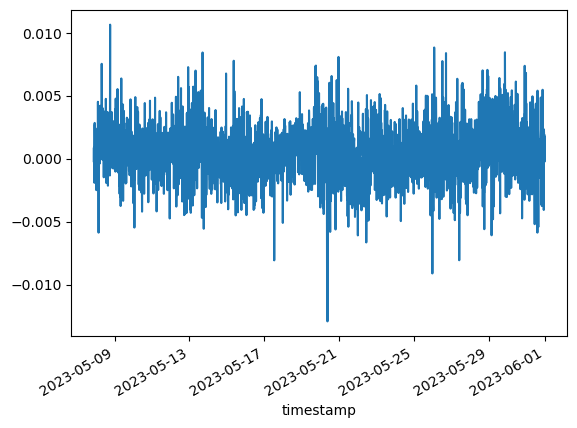

In [5]:
residuals = targets_ - mean_preds
residuals.plot()

In [6]:
# Prior beliefs
prior_mean = residuals[0:1000].mean()  # Your prior mean
prior_std = residuals[0:1000].std()   # Your prior standard deviation


In [7]:
from scipy import stats

data = [6, 9, 12, 7, 8, 8, 13]

mean, var, std = stats.bayes_mvs(data)

In [8]:
var

Variance(statistic=10.0, minmax=(3.1767242068607078, 24.45910382133402))

In [9]:
import scipy
from scipy import stats
stats.bayes_mvs(residuals, alpha=0.9)

(Mean(statistic=0.0004296445126164316, minmax=(0.00036856446886973947, 0.0004907245563631236)),
 Variance(statistic=4.499468741691804e-06, minmax=(4.316239427197888e-06, 4.682698056185719e-06)),
 Std_dev(statistic=0.0021211951210795776, minmax=(0.0020780050079511206, 0.0021643852342080345)))

In [21]:
res_mean, res_var, res_std = stats.bayes_mvs(residuals[0:3], alpha=0.99)
res_mean

Mean(statistic=0.00011021284840754635, minmax=(-0.0037053618929680475, 0.00392578758978314))

In [24]:
res_mean, res_var, res_std = stats.bayes_mvs(residuals[0:1000], alpha=0.99)
res_mean

Mean(statistic=0.0005702656169097756, minmax=(0.0004121507696320625, 0.0007283804641874886))

In [15]:
res_mean

Mean(statistic=0.0004296445126164316, minmax=(0.00033399359026878615, 0.0005252954349640771))

In [10]:
import pymc3 as pm
import numpy as np

# Bayesian model
with pm.Model() as model:
    # Prior distribution for the parameter
    parameter = pm.Normal('parameter', mu=prior_mean, sd=prior_std)
    
    # Likelihood of the data
    likelihood = pm.Normal('likelihood', mu=parameter, sd=1, observed=data)
    
    # Sample from the posterior distribution
    trace = pm.sample(1000, tune=1000)
    
# Calculate credible interval
credible_interval = pm.stats.hpd(trace['parameter'], hdi_prob=0.95)

# Calculate required sample size
required_sample_size = ...  # Calculate this based on credible interval width

# Aggregate predictions
aggregated_prediction = np.mean(data[:required_sample_size])

# Print results
print("Credible Interval:", credible_interval)
print("Required Sample Size:", required_sample_size)
print("Aggregated Prediction:", aggregated_prediction)

ModuleNotFoundError: No module named 'pymc3'